# Thesis Bell KPI Notebook
This notebook explores regression models applied to daily kpi data  

In [74]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime as dt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from  InvarianceTestEllipsoid import InvarianceTestEllipsoid
from autocorrelation import autocorrelation
from scipy import stats
import scipy.signal as sig
import statsmodels.api as sm

#importing the data
kpi = pd.read_excel("productivity.xlsx")
weather = pd.read_excel("weather.xlsx")
weather = weather[weather["Total Precip Flag"] != "T"]
weather = weather.set_index(weather["Date/Time"])
kpi = kpi.set_index(kpi["Date"])
kpi["Date"] = pd.to_datetime(kpi["Date"], format="%m/%d/%Y")
#group the data by date and get the aggregate daily kpis
grouped = kpi.groupby('Date')
kpi = kpi[kpi.index.dayofweek <5]
#unit_kpi = pd.DataFrame(grouped.sum()["Locations Passed"]/grouped.count()['Foreman'])

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: FutureWarning: 'Date' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version


## I am going to use the index of adding up all the work being done
#### Each unit of work gets paid at different rates however for simplicity 

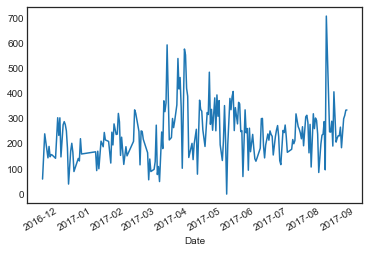

In [75]:
#add up all the metres drilled work 
unit_kpi = pd.DataFrame((grouped.sum()["Metres Prepped"]+grouped.sum()["Meters Drilled"]+grouped.sum()["Meters Cleaned Up"])/grouped.count()['Foreman'])
unit_kpi["Date/Time"] = unit_kpi.index

unit_kpi.columns = ['kpi', 'Date/Time']
unit_kpi = unit_kpi.dropna()
full_data = pd.merge(unit_kpi,weather,on = "Date/Time")
full_data = full_data[full_data.kpi <550] #I have been informed that these days are 
#called adjustment days that are not actually occuring on the day it is logged 
#make the index dates 
full_data.index = full_data["Date/Time"]
unit_kpi.kpi.plot();

## Dropping a lot of useless fields

In [76]:
full_data = full_data.drop(['Year', 'Month', 'Day', 'Data Quality','Max Temp (°C)', 
                            'Max Temp Flag', 'Min Temp (°C)', 'Min Temp Flag',
                            'Mean Temp Flag',
                            'Heat Deg Days Flag', 
                            'Cool Deg Days Flag','Total Precip Flag',
                            'Snow on Grnd (cm)', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)',
                             'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)',
                              'Spd of Max Gust Flag','Total Rain Flag','Total Snow (cm)','Total Snow Flag'],axis =1)

# Optimal lag selection using AR process (tutorial)
$M_{t+1} = \alpha_0 + \alpha_1M_t + \epsilon_t$
where $\epsilon_t$ is $iid$

In [77]:
full_data.to_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\kpi.pkl")
model = sm.tsa.AR(full_data.kpi)
results= model.fit(maxlag = 10, ic = "bic",method = 'cmle')

In [78]:
a = sm.tsa.AR(full_data.kpi).select_order(maxlag = 10, ic = 'bic',method='cmle')

In [79]:
a

1

In [80]:
results.params

const     150.080378
L1.kpi      0.363096
dtype: float64

## Regression model #3
why try and get the iid invariants all at once... instead try and model the residuals separately as it is supported by literature as per Koehen&Brown:

$M_{t} = \alpha_0 + \alpha_1T_t +\alpha_2T_t^2+\alpha_4P_t + \epsilon_t$
where $\epsilon_t$ is $iid$ ? Most likely not so lets use a k lag auto regression process

$\epsilon_t = \sum_{i = 1}^{k} \rho_i \epsilon_{t-i} + \zeta_t$

where $\zeta_t$ is iid

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     6.683
Date:                Sat, 09 Dec 2017   Prob (F-statistic):           0.000279
Time:                        14:48:52   Log-Likelihood:                -952.07
No. Observations:                 164   AIC:                             1910.
Df Residuals:                     161   BIC:                             1919.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Mean Temp (°C)        4.5835      1.33

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


1.546140993013978e-11

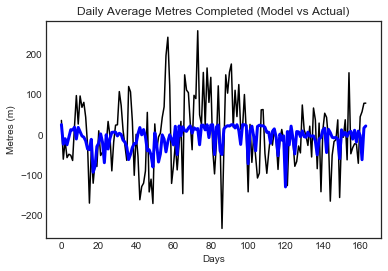

In [81]:
factors = full_data.dropna()
X = factors[["Mean Temp (°C)",'Total Precip (mm)']]
X["Mean Temp Squared"]= factors["Mean Temp (°C)"]**2
Y = factors.kpi
Y = np.array(pd.Series(sig.detrend(Y))) #linear detrending for now (most likely will not be able to share the trend)
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

Yp = results.predict()
e = Y  - Yp

plt.plot(Y,  color='black')
plt.plot(Yp, color='blue',linewidth=3)
plt.title('Daily Average Metres Completed (Model vs Actual)')
plt.ylabel("Metres (m)")
plt.xlabel("Days")
plt.legend()
Y.sum()

In [82]:
armodel = sm.tsa.AR(e)
arresults= armodel.fit(maxlag = 30, ic = "bic",method = 'cmle')
print("The maximum number of required lags for the residuals above according to the Bayes Information Criterion is:")
sm.tsa.AR(e).select_order(maxlag = 10, ic = 'aic',method='cmle')

The maximum number of required lags for the residuals above according to the Bayes Information Criterion is:


1

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     19.62
Date:                Sat, 09 Dec 2017   Prob (F-statistic):           1.73e-05
Time:                        14:48:53   Log-Likelihood:                -937.44
No. Observations:                 163   AIC:                             1877.
Df Residuals:                     162   BIC:                             1880.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3292      0.074      4.430      0.0

(1, 163)

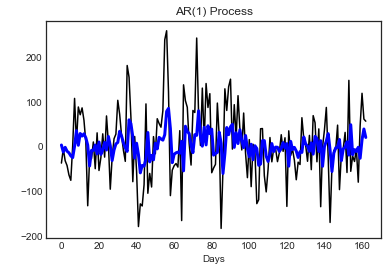

In [83]:
res_mod = sm.OLS(e[1:], e[:-1])
res_res = res_mod.fit()
print(res_res.summary())

ep = res_res.predict()
print(len(ep),len(e))
z = ep - e[1:]

plt.plot(e[1:],  color='black')
plt.plot(ep, color='blue',linewidth=3)
plt.title('AR(1) Process')
plt.ylabel(" ")
plt.xlabel("Days")
plt.legend()
z = np.expand_dims(z,axis = 0)
z.shape

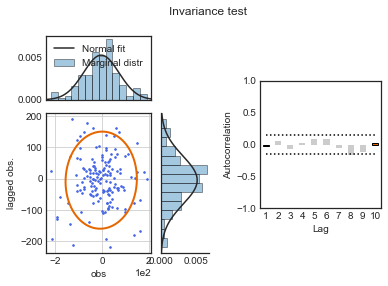

In [84]:
lag_ = 10 # number of lags (for auto correlation test)
acf = autocorrelation(z, lag_)

lag = 10 # lag to be printed
ell_scale = 2 # ellipsoid radius coefficient
fit = 1  # normal fitting

InvarianceTestEllipsoid(z, acf[0,1:], lag, fit, ell_scale);

In [85]:
results.params

Mean Temp (°C)       4.583546
Total Precip (mm)   -2.982463
Mean Temp Squared   -0.205831
dtype: float64

### Monte Carlo Simulation of the Meters index:


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


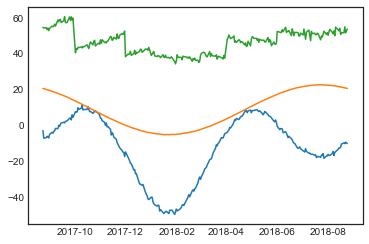

In [86]:
tau = 365
M = 10000 

epsi = np.random.choice(z[0,:],[tau,M])
AR = np.zeros(epsi.shape)
for i in range(epsi.shape[0]-1):
    AR[i+1,] = res_res.params[0]*AR[i,]+ epsi[i,]

Tin = pd.read_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\Tout.pkl")

Pin = pd.read_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\Pout.pkl")

eta = pd.read_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\Tinnov.pkl")

Tin = Tin.ix[full_data["Date/Time"][-1]:full_data["Date/Time"][-1]+dt.timedelta(days=tau)]
Pin = Pin.ix[full_data["Date/Time"][-1]:full_data["Date/Time"][-1]+dt.timedelta(days=tau)]

Tin= Tin[Tin.index.dayofweek <5]
Pin= Pin[Pin.index.dayofweek <5]

X = np.zeros([len(Pin),M,len(results.params)])
X[:,:,0] = np.array(Tin)
X[:,:,1] = np.array(Pin)
X[:,:,2] = np.array(Tin**2)
Meters = np.zeros([len(Pin),M])

for i in range(M):
    Meters[:,i] = results.predict(X[:,i,:])
Meters = Meters+AR[:len(Meters),]

#inducing an artificial trend for the data to make sense 

meters_ = np.linspace(400,400*(1+10/100)*tau/365,Meters.shape[0])
M_t = (Meters.transpose()+meters_).transpose()
# plotting a sample path 
plt.plot(Tin.index,Meters.mean(axis = 1));
#full_data.kpi.plot()
plt.plot(Tin.index,Tin.mean(axis=1));
plt.plot(Tin.index,20*Pin.mean(axis=1));

### A sample projected path 

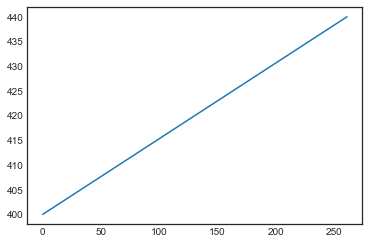

In [87]:
plt.plot(meters_)

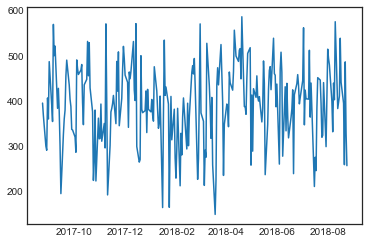

In [88]:
# plotting a sample path 
plt.plot(Tin.index,M_t[:,1]);
#full_data.kpi.plot();

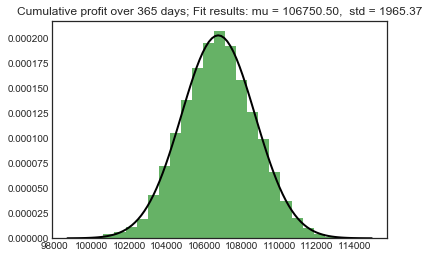

In [89]:
from scipy.stats import norm
# Fit a normal distribution to the data:
mu, std = norm.fit(M_t.sum(axis=0))

# Plot the histogram.
plt.hist(M_t.sum(axis=0), bins=25, normed=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Cumulative profit over " + str(tau)+ " days; Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

### Taking the meters drilled and converting it to a loss distribution
$M_{t+\tau} --> L_{t+\tau}$ by assuming a 1 dollar profit and a fixed cost $F = 0.33E_{t+\tau}(M)$

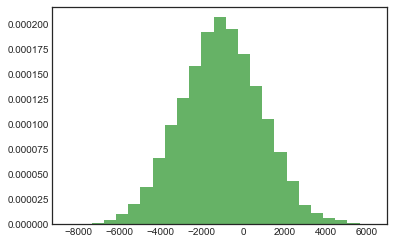

In [90]:
L0 = 0.99*M_t.sum(axis=0).mean() - M_t.sum(axis=0)
plt.hist(L0, bins=25, normed=True, alpha=0.6, color='g');
pd.Series(L0).to_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\Loss.pkl")